In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Data visualization
import umap
import matplotlib.pyplot as plt

2023-04-20 18:00:13.192567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 18:00:13.371818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-20 18:00:13.371832: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-20 18:00:13.978517: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# Load training set from csv
X_train = pd.read_csv('UNSW_NB15_training-set.csv', header=0, index_col=0)
X_test = pd.read_csv('UNSW_NB15_testing-set.csv', header=0, index_col=0)
X = pd.concat([X_train,X_test])

In [11]:
X.head()

dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
id                                                                          
1   0.121478   tcp       -   FIN      6      4     258     172  74.087490   
2   0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
3   1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
4   1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
5   0.449454   tcp       -   FIN     10      6     534     268  33.373826   

    sttl  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
id        ...                                                               
1    252  ...                 1               1             0           0   
2     62  ...                 1               2             0           0   
3     62  ...                 1               3             0           0   
4     62  ...                 1               3             1           1   
5    254  ...                 1              40             0           0   

    ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
id                                                                          
1                  0           1           1                0      Normal   
2                  0           1           6                0      Normal   
3                  0           2           6                0      Normal   
4                  0           2           1                0      Normal   
5                  0           2          39                0      Normal   

    label  
id         
1       0  
2       0  
3       0  
4       0  
5       0  

[5 rows x 44 columns]

In [12]:
# Get data types
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 1 to 82332
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  din

In [13]:
# Check if any data is invalid (NaN)
X.isnull().sum().sum()

0

In [17]:
# Sanity check values
print(X.is_sm_ips_ports.value_counts())
print(X.ct_state_ttl.value_counts())
print(X.is_ftp_login.value_counts())

0    253995
1      3678
Name: is_sm_ips_ports, dtype: int64
2    116154
1     76589
0     57836
6      3734
3      3331
4        28
5         1
Name: ct_state_ttl, dtype: int64
0    254428
1      3219
4        16
2        10
Name: is_ftp_login, dtype: int64


In [4]:
# Factorize string-type features
codes_proto, uniques_proto = pd.factorize(X['proto'])
X['proto'] = codes_proto
codes_service, uniques_service = pd.factorize(X['service'])
X['service'] = codes_service
codes_state, uniques_state = pd.factorize(X['state'])
X['state'] = codes_state

In [5]:
# Drop attack category
X = X.drop('attack_cat', axis=1)

In [6]:
# Check number of normal and attack data instances
print(f'Normal traffic: {X[X.label == 0].label.size}, Attack traffic: {X[X.label == 1].label.size}')

Normal traffic: 93000, Attack traffic: 164673


In [7]:
print(X.corr()['label'].sort_values(ascending=False))

label                1.000000
sttl                 0.624082
ct_state_ttl         0.476559
ct_dst_sport_ltm     0.371672
rate                 0.335883
ct_src_dport_ltm     0.318518
ct_dst_src_ltm       0.299609
ct_src_ltm           0.252498
ct_srv_dst           0.247812
ct_srv_src           0.246596
ct_dst_ltm           0.240776
proto                0.237382
service              0.232546
sload                0.165249
state                0.039292
dur                  0.029096
sbytes               0.019376
dttl                 0.019369
trans_depth          0.002246
sloss                0.001828
ackdat               0.000817
is_ftp_login        -0.008762
ct_ftp_cmd          -0.009092
ct_flw_http_mthd    -0.012237
sjit                -0.016436
response_body_len   -0.018930
tcprtt              -0.024668
smean               -0.028372
dinpkt              -0.030136
spkts               -0.043040
synack              -0.043250
djit                -0.048819
dbytes              -0.060403
dloss     

UMAP( verbose=True)
Thu Apr 20 18:00:49 2023 Construct fuzzy simplicial set
Thu Apr 20 18:00:49 2023 Finding Nearest Neighbors
Thu Apr 20 18:00:49 2023 Building RP forest with 30 trees
Thu Apr 20 18:00:50 2023 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	Stopping threshold met -- exiting after 2 iterations
Thu Apr 20 18:00:59 2023 Finished Nearest Neighbor Search
Thu Apr 20 18:01:02 2023 Construct embedding


/home/panopticon/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/panopticon/.local/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/panopticon/.local/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/panopticon/.local/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too sma

Epochs completed:   0%|            0/200 [00:00]

Thu Apr 20 18:32:45 2023 Finished embedding


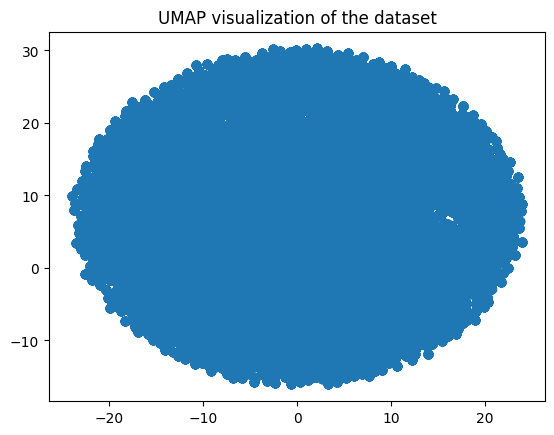

In [8]:
# Create a UMAP model with 2 components
umap_model = umap.UMAP(n_components=2,verbose=True)

# Fit the UMAP model to the data and transform the data
umap_embeddings = umap_model.fit_transform(X)

[[ -2.4858093    5.462769  ]
 [ -0.82772475   6.452896  ]
 [ -0.55350214   8.801955  ]
 ...
 [-19.826733    -0.9824187 ]
 [ 11.582426    -0.7309145 ]
 [  9.288111    -3.0700748 ]]


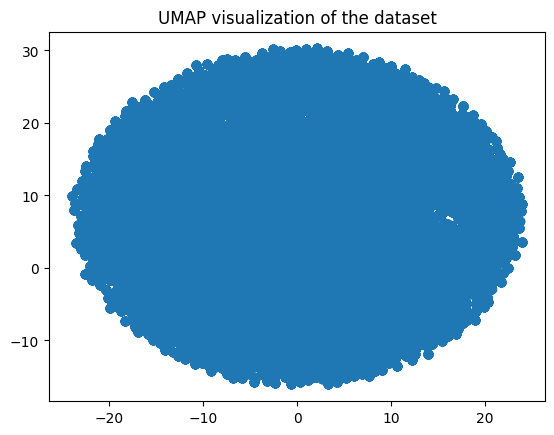

In [10]:
print(umap_embeddings)
# Visualize the UMAP embeddings
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1])
plt.title('UMAP visualization of the dataset')
plt.show()